In [1]:
# libraries
using Random, Distributions, Statistics, DataFrames

In [320]:
stop_cost = 20
ticket_price = 5
pass_cost = 3.5
ticket_penalty = 20
n_bus = 5
max_pas = 60



20

In [2]:
function bus_ride(;
    n_stops = 7,
    max_pass = 60,
    avg_bus = 10,
    n_passengers = 15,
    n_control,
    stop_cost,
    ticket_price = 0,
    pass_cost = 3.5,
    p_control = 0.05,
    ticket_penalty = 20,
    control_cost = 50,
    controlled = false)

    @assert pass_cost <= ticket_price
    n_passengers = rand(max((n_passengers - 4), 0):(n_passengers + 4))
    n_passengers = min(n_passengers, max_pass)
    
    control_ability = max_pass/3

    bus_revenue = 0.0
    tot_freeriders = 0
    n_freerider = 0
    paid = 0
    bus_penalty = 0

    p_freerider = ticket_price/(ticket_price + ticket_penalty^2)

    for pass in 1:n_passengers
        if rand() <= p_freerider
            n_freerider += 1
            tot_freeriders += 1
        else
            paid += 1
        end
    end

    pois = Distributions.Poisson(avg_bus)
    for stop in 1:n_stops
        if rand() <= 0.6 # check if bus stops at a stop
            pass_exit = rand(pois)
            pass_exit = min(pass_exit, n_passengers)
            n_freerider -= rand(0:pass_exit)
            
            n_passengers -= pass_exit # updating number of passengers
            n_freerider = max(n_freerider, 0)
            n_freerider = min(n_freerider, n_passengers)

            pass_new = rand(pois)
            available_seats = max_pass - n_passengers
            pass_new = min(pass_new, available_seats) 
            n_passengers += pass_new # updating number of passengers
            @assert (n_passengers >= 0 && n_passengers <= max_pass)

            for pass in 1:pass_new
                if rand() <= p_freerider
                    n_freerider += 1
                    tot_freeriders += 1
                else
                    paid += 1
                end
            end

            if ((controlled == false) & (n_control > 0) & (rand() <= p_control))
                if n_passengers <= control_ability
                    bus_penalty = n_freerider * ticket_penalty
                else 
                    if n_freerider > 0
                        for freerider in 1:n_freerider
                            if rand() <= 1 - n_passengers/max_pass
                                bus_penalty += ticket_penalty
                            end
                        end
                    end
                end
                controlled = true
                n_control -= 1
            end
        end
    end
    bus_revenue = paid * (ticket_price - pass_cost) + bus_penalty - n_stops * stop_cost - tot_freeriders * pass_cost - controlled * control_cost
    (; bus_revenue, n_control, controlled)
end
            

bus_ride (generic function with 1 method)

In [3]:
bus_ride(n_control = 10, stop_cost = 0, avg_bus = 0, n_passengers = 0, max_pass = 0, ticket_price = 0, pass_cost = 0)

(bus_revenue = 0, n_control = 10, controlled = false)

In [4]:

function bus_p(max_pas)
    n_stops = rand(10:20)
    max_pass = max_pas
    avg_bus = min(rand(Distributions.Poisson(30)), max_pass)
    n_passengers = 15
    n_trips = rand(10:15)
    (; n_stops, max_pass, avg_bus, n_passengers, n_trips)
end


bus_p (generic function with 1 method)

In [14]:
function one_period(;
    n_control = 10,
    ndays = 30,
    max_pas = 60,
    stop_cost = 20,
    ticket_price = 5,
    pass_cost = 5,
    ticket_penalty = 20,
    n_bus = 50,
    control_cost = 50)
    

    bus_par = DataFrame(bus_p(max_pas) for _ in 1:n_bus)

    control_left = []
    max_trips = maximum(bus_par.n_trips)
    total_revenue = 0.0
    day_rev = Float64[]
    for day in 1:ndays
        control_num = n_control
        day_revenue = 0.0

        for i in 1:max_trips
            for bus in 1:n_bus
                if bus_par.n_trips[bus] >= i
                    ride_rev, control_num = bus_ride(
                        n_stops = bus_par.n_stops[bus], 
                        max_pass = bus_par.max_pass[bus], 
                        avg_bus = bus_par.avg_bus[bus], 
                        n_passengers = bus_par.n_passengers[bus], 
                        n_control = control_num,
                        stop_cost = stop_cost,
                        ticket_price = ticket_price,
                        pass_cost = pass_cost,
                        ticket_penalty = ticket_penalty,
                        control_cost = control_cost)
                    day_revenue += ride_rev
                end
            end
        end

        push!(control_left, control_num)
        total_revenue += day_revenue
        push!(day_rev, day_revenue)
    end
    (; total_revenue, day_rev, control_left)
end



one_period (generic function with 1 method)

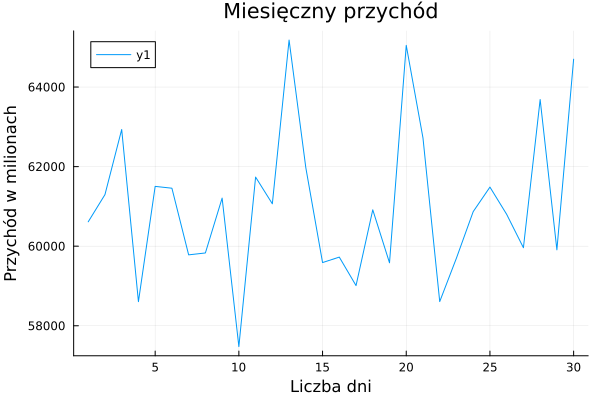

In [15]:
month = one_period(n_control = 100, ticket_penalty = 200, pass_cost = 3.5)
using Plots
plot(month.day_rev)
xlabel!("Liczba dni")
ylabel!("Przychód w milionach")
title!("Miesięczny przychód")

In [35]:
function run(;
    n_control = 10,
    ndays = 30,
    max_pas = 60,
    stop_cost = 20,
    ticket_price = 5,
    pass_cost = 5,
    ticket_penalty = 20,
    n_bus = 10,
    control_cost = 50,
    n_iter = 1000)
    df = DataFrame(one_period(;n_control, ndays, max_pas, stop_cost, ticket_price, pass_cost, ticket_penalty, n_bus, control_cost) for _ in 1:n_iter)
    (
    control_number = n_control,
    passenger_cost = pass_cost,
    ticket_price = ticket_price,
    ticket_penalty = ticket_penalty,
    control_cost = control_cost,
    revenue_mean = mean(df.total_revenue),
    revenue_std = std(df.total_revenue)
    )
end

df = DataFrame(
    run(;n_control, ticket_price = 5, ticket_penalty, control_cost = 20, pass_cost = 3.5) 
    for ticket_penalty in 0.0:5.0:200.0, n_control in 10:5:100, ticket_price in 4:1:10)

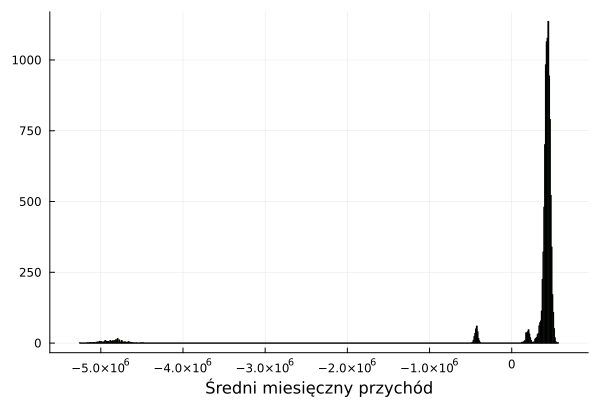

In [27]:
using Plots

histogram(df.revenue_mean, 
    legend = false, 
    xlabel = "Średni miesięczny przychód", 
    color="lightgreen",
    bins=1000)

In [31]:
best_row = argmax(df.revenue_mean)
df[best_row,:]

,control_number,passenger_cost,ticket_price,ticket_penalty,control_cost,revenue_mean
,Int64,Float64,Int64,Float64,Int64,Float64
3183,15,3.5,5,125.0,20,5.62554e5


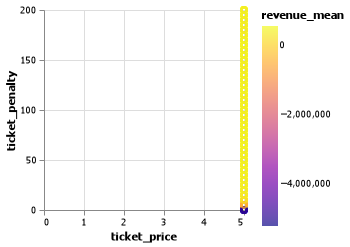

In [34]:
using VegaLite
df |> @vlplot(:point, x=:ticket_price, y=:ticket_penalty, color={:revenue_mean, scale={scheme=:plasma}})

In [29]:
function heatmap_data(column1, column2, column3)
    uni = unique(column1)
    vectors1 = []
    vectors2 = []
    vectors3 = []
    for i in uni
        filter = findall(==(i), column1)
        vector1 = column1[filter]
        vector2 = column2[filter]
        vector3 = column3[filter]

        append!(vectors1,vector1)
        append!(vectors2,vector2)
        append!(vectors3,vector3)
    end


    uni_size_1 = size(unique(column1),1)
    uni_size_2 = size(unique(column2),1)
    uni_1 = unique(column1)
    uni_2 = unique(column2)
    
    data_heat = reshape(vectors3, uni_size_1, uni_size_2)

    (data_heat=data_heat, uni_1=uni_1, uni_2=uni_2)
end


heatmap_data (generic function with 1 method)

In [30]:
data_heat, uni_control, uni_ticket = heatmap_data(df.control_number, df.ticket_penalty, df.revenue_mean)
heatmap( uni_ticket, uni_control, data_heat',
    title = "Heatmap - Średnie przychody",
    xlabel = "Liczba kontroli",
    ylabel = "Wartość mandatu")


LoadError: DimensionMismatch: new dimensions (19, 41) must be consistent with array size 10127